# Point classification

## Step 1 - building the input

We will (randomly) generate some points in a bidimensional space.

These points will be divided into two groups:
- a cluster of points, in the middle of the plot (around 0;0)
- a circle of points, surrounding the cluster

After that, we will use Keras to build a neural network and train it for us so it should be able to classificate any point into one of the two groups.


## Step 2 - the neural network

The **input** for the network will be bidimensional, a point defined by its two coordinates.
The **output** of the network will also be bidimensional: 
  1. confidence for the point to be part of the cluster
  2. confidence for the point to be part of the circle.
  
***

In [60]:
# Import some very common external modules

import numpy as np
import matplotlib.pyplot as plt
import random

Let's see how to use numpy for generating some random values.

We are going to generate 100 random numbers *around* the value 42.
In this case, *around* means that the value will be generated using a normal (*gaussian*) distribution with a variation of 1. We can expect the most of the numbers to be in the range [42-1, 42+1].

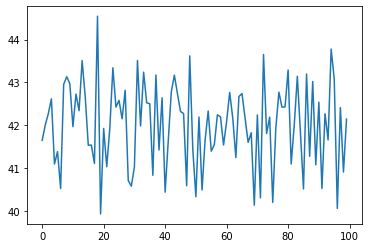

In [61]:
values = np.random.normal(42, 1, 100)

# plot those values, as simple as a call using matplotlib!
plt.plot(values)

# (note: if you run this cell multiple times you'll see that the values are changing everytime)

We are now going to dive a little deeper in our exercise. It's time to generate the random points.

We actually are going to generate two different lists: one for the Xs, and one for the Ys coordinates.

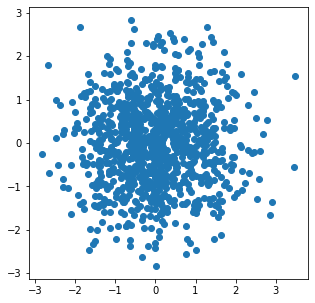

In [62]:
def generate_inner_cluster(variation, how_many):
    center = 0
    x = np.random.normal(center, variation, how_many)
    y = np.random.normal(center, variation, how_many)
    return x, y

plt.figure(figsize=(5,5))  # in questo modo è possibile controllare la dimensione del grafico
plt.scatter(*generate_inner_cluster(1, 1000))

Now it's time to generate a circle of points. There's some math magic going on here that may require an additional read before getting into it. Our function is basically going to:
    1. generate a list of random "distances" from the center
    2. generate a list of equidistant angles in the range [0, 2pi]
    3. get coordinates for each point with trigonometry


well, it's not magic, just [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system) :)

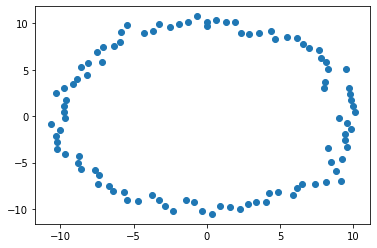

In [63]:
def generate_outer_circle(radius, variation, how_many):
    r = np.random.normal(radius, variation, how_many) # list of distances
    phi = np.linspace(0, 2.*np.pi, len(r))            # list of angles
    x = r * np.sin(phi)                               # polar to cartesian conversion
    y = r * np.cos(phi)
    return x, y

plt.scatter(*generate_outer_circle(10, 0.5, 100))

Putting all the pieces so far:

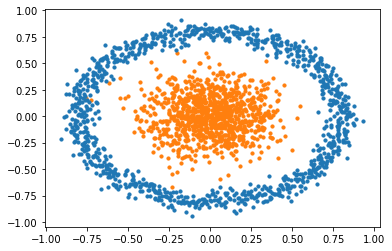

In [64]:
how_many_points = 1000

x_inner, y_inner = generate_inner_cluster(0.2, how_many_points)
plt.scatter(x_inner, y_inner, s=10, c="C1")

x_circle, y_circle = generate_outer_circle(0.8, 0.05, how_many_points)
plt.scatter(x_circle, y_circle, s=10)

***

## It's time for some ML

In [107]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

Build the model using Keras, easy peasy lemon squeezy

In [108]:
model = Sequential([
    Dense(7, input_shape=(2,), activation="relu"),
    Dense(5, input_shape=(2,), activation="relu"),
    Dense(2, activation="softmax"),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [109]:
def zip_lists(list1, list2):
    '''
    take two lists, e.g.:
        list1: [1, 2, 3]
        list2: [9, 8, 7]
        
    returns a numpy array:
        [ [1,9], [2,8], [3,7] ]
    '''
    return np.array(list(zip(list1, list2)))


def make_dataset(num):
    input_circle = zip_lists(*generate_outer_circle(0.8, 0.05, num))
    output_circle = np.array([[0, 1]] * num)

    input_inner = zip_lists(*generate_inner_cluster(0.2, num))
    output_inner = np.array([[1, 0]] * num)

    points = np.concatenate((input_circle, input_inner))    # [ [2,1], [3,4], [5,6], ... ]
    output = np.concatenate((output_circle, output_inner))  # [ [0,1], [0,1], [1,0], ... ]

    return points, output

training_set = make_dataset(10000)
test_set = make_dataset(10000)

training_set

(array([[0.00000000e+00, 7.30113289e-01],
        [5.23087120e-04, 8.32435646e-01],
        [1.01798215e-03, 8.10003023e-01],
        ...,
        [1.10228743e-01, 4.86227550e-01],
        [1.33877574e-01, 8.43211069e-02],
        [3.33696656e-01, 1.00299081e-02]]), array([[0, 1],
        [0, 1],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]]))

A dataset generated by our make_dataset is a tuple [points, outputs]. Each point is a couple [x, y] and each output is a couple of probability [inner, circle] for the point of belonging to that zone.

Keras is ready to train the net with our *training_set*. We are also specifying that it should shuffle data (that helps reducing overfitting introduced by our data being ordered) and use *test_set* to validate the model (i.e. for computing the **loss function**).

In [110]:
history = model.fit(
            training_set[0], training_set[1],
            epochs=40,
            batch_size=512,
            shuffle=True,
            validation_data=(test_set[0], test_set[1])
          ).history

Train on 20000 samples, validate on 20000 samples
Epoch 1/40
20000/20000 [==============================] - 0s 7us/step - loss: 0.6719 - accuracy: 0.5825 - val_loss: 0.6637 - val_accuracy: 0.6269
Epoch 2/40
20000/20000 [==============================] - 0s 4us/step - loss: 0.6548 - accuracy: 0.6629 - val_loss: 0.6436 - val_accuracy: 0.6920
Epoch 3/40
20000/20000 [==============================] - 0s 3us/step - loss: 0.6314 - accuracy: 0.7160 - val_loss: 0.6155 - val_accuracy: 0.7399
Epoch 4/40
20000/20000 [==============================] - 0s 3us/step - loss: 0.5990 - accuracy: 0.7580 - val_loss: 0.5785 - val_accuracy: 0.7858
Epoch 5/40
20000/20000 [==============================] - 0s 4us/step - loss: 0.5592 - accuracy: 0.8040 - val_loss: 0.5364 - val_accuracy: 0.8235
Epoch 6/40
20000/20000 [==============================] - 0s 3us/step - loss: 0.5166 - accuracy: 0.8374 - val_loss: 0.4939 - val_accuracy: 0.8521
Epoch 7/40
20000/20000 [==============================] - 0s 3us/step - lo

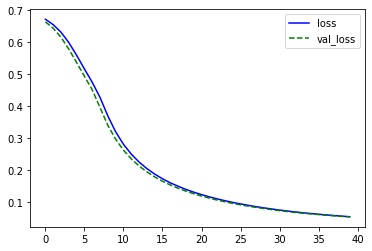

In [114]:
plt.plot(history['loss'], color='b', label='loss')
plt.plot(history['val_loss'], color='g', 
linestyle='--', label='val_loss')
plt.legend()
plt.show()

## Let's predict

In [120]:
points = np.array([
    [0, 1],
    [0, 0]
])

# we input a list of points, and receive back a list of confidences
model.predict(points)

array([[1.6569842e-04, 9.9983430e-01],
       [9.4376731e-01, 5.6232624e-02]], dtype=float32)

In [123]:
# argmax it's pretty useful for selecting the most probable zone for the point
predictions = model.predict(points)
[np.argmax(prediction) for prediction in predictions]

[1, 0]

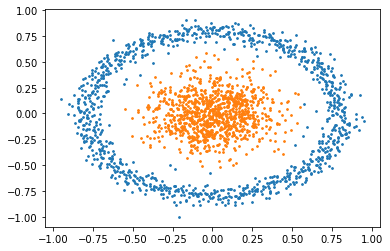

In [139]:
# build some real points
points, real = make_dataset(1000)
predictions = model.predict(points)

circle = []
inner = []

for i in range(len(points)):
    if np.argmax(predictions[i]) == 0:
        circle.append(points[i])
    else:
        inner.append(points[i])

plt.scatter(*zip(*inner), s=3)
plt.scatter(*zip(*circle), s=3)


That's it for that example. Hopefully it's pretty clear even for the ones that never saw numpy, matplotlib, keras, and all that pythonic mess.

If something can be done better, open an issue on the GitHub repo. I'll be happy to improve all I can :)